In [92]:
import json
import pickle
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import seaborn as sns
from datasets import load_dataset, Dataset
import warnings
warnings.filterwarnings("ignore")

In [368]:
models_dict = {
    'Base': {
        'short_name': 'base', 
        'full_name': 'ALMA-13B-SFT-HW', 
    },
    'SFT-Multi-xCOMET-QE': {
        'short_name': 'sft_xcomet_multi',
        'full_name': 'ALMA-13B-SFT-HW-SFT-Multi-xCOMET-QE', 
    },
    'SFT-Multi-CometKiwi': {
        'short_name': 'sft_kiwi_multi',
        'full_name': 'ALMA-13B-SFT-HW-SFT-Multi-CometKiwi', 
    },
    'SFT-Multi-chrF': {
        'short_name': 'sft_chrf_multi',
        'full_name': 'ALMA-13B-SFT-HW-SFT-Multi-chrF',
    },
    'CPO-Multi-xCOMET-QE': {
        'short_name': 'cpo_xcomet_multi',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Multi-xCOMET-QE',
    },
    'CPO-Multi-xCOMET-QE-Choose-Base': {
        'short_name': 'cpo_xcomet_multi_cb',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Multi-xCOMET-QE-Choose-Base',
    },
    'CPO-Multi-CometKiwi': {
        'short_name': 'cpo_kiwi_multi',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Multi-CometKiwi',
    },
    'CPO-Multi-chrF': {
        'short_name': 'cpo_chrf_multi',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Multi-chrF',
    },
    'CPO-Mono-xCOMET-QE': {
        'short_name': 'cpo_xcomet_mono',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Mono-xCOMET-QE',
    }, 
    'CPO-Mono-xCOMET-QE-Choose-Low-Reject-Low': {
        'short_name': 'cpo_xcomet_mono_cl_rl',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Mono-xCOMET-QE-Choose-Low-Reject-Low',
    },
    'CPO-Mono-xCOMET-QE-Choose-Low-Reject-Mid': {
        'short_name': 'cpo_xcomet_mono_cl_rm',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Mono-xCOMET-QE-Choose-Low-Reject-Mid',
    },
    'CPO-Mono-xCOMET-QE-Choose-Low-Reject-High': {
        'short_name': 'cpo_xcomet_mono_cl_rh',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Mono-xCOMET-QE-Choose-Low-Reject-High',
    },
    'CPO-Mono-xCOMET-QE-Choose-Mid-Reject-Low': {
        'short_name': 'cpo_xcomet_mono_cm_rl',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Mono-xCOMET-QE-Choose-Mid-Reject-Low',
    },
    'CPO-Mono-xCOMET-QE-Choose-Mid-Reject-Mid': {
        'short_name': 'cpo_xcomet_mono_cm_rm',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Mono-xCOMET-QE-Choose-Mid-Reject-Mid',
    },
    'CPO-Mono-xCOMET-QE-Choose-Mid-Reject-High': {
        'short_name': 'cpo_xcomet_mono_cm_rh',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Mono-xCOMET-QE-Choose-Mid-Reject-High',
    },    
    'CPO-Mono-xCOMET-QE-Choose-High-Reject-Low': {
        'short_name': 'cpo_xcomet_mono_ch_rl',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Mono-xCOMET-QE-Choose-High-Reject-Low',
    },
    'CPO-Mono-xCOMET-QE-Choose-High-Reject-Mid': {
        'short_name': 'cpo_xcomet_mono_ch_rm',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Mono-xCOMET-QE-Choose-High-Reject-Mid',
    },
    'CPO-Mono-xCOMET-QE-Choose-High-Reject-High': {
        'short_name': 'cpo_xcomet_mono_ch_rh',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Mono-xCOMET-QE-Choose-High-Reject-High',
    },
    'CPO-Mono-xCOMET-QE-Optimized': {
        'short_name': 'cpo_xcomet_mono_ch_rm',
        'full_name': 'ALMA-13B-SFT-HW-CPO-Mono-xCOMET-QE-Choose-High-Reject-Mid',
    },
}

metrics_dict = {
    'xCOMET-QE': {'short_name': 'xcomet', 'type': 'Neural'},
    'CometKiwi': {'short_name': 'kiwi', 'type': 'Neural'},
    'chrF': {'short_name': 'chrf', 'type': 'Lexical'},
    'Comet22': {'short_name': 'comet', 'type': 'Neural'},
    'MetricX': {'short_name': 'metricx', 'type': 'Neural'},
    'BLEU': {'short_name': 'bleu', 'type': 'Lexical'},
}

In [ ]:
eval_df = load_dataset("hgissbkh/WMT22-23-Test-Metrics")["train"].to_pandas()

In [ ]:
# hf_data_path = "hgissbkh/WMT22-23-Metrics-v2"
# ft_data_path = "../data/training/{DATASET_NAME}"
# eval_data_path = "../data/evaluation/WMT22-23-Test/{MODEL_NAME}"

In [151]:
# # Add metricx
# for k, v in models_dict.items():
#     file_path = eval_data_path.format(MODEL_NAME=v["full_name"]) + "/metricx_output.jsonl"
#     metricx = []
#     try:
#         with open(file_path, 'r') as file:
#             for line in file:
#                 metricx.append(json.loads(line)["prediction"])
#         eval_df[f"{v['short_name']}_metricx"] = metricx
#     except:
#         pass

# # Add Comet22
# for k, v in models_dict.items():
#     file_path = eval_data_path.format(MODEL_NAME=v["full_name"]) + "/comet_greedy.pkl"
#     comet = []
#     try:
#         with open(file_path, 'rb') as file:
#             comet = pickle.load(file)
#         eval_df[f"{v['short_name']}_comet"] = [x*100 for x in comet]
#     except:
#         pass

In [168]:
# Put columns in right order
# eval_df_2 = pd.DataFrame()
# eval_df_2[["lp", "src_lang", "tgt_lang", "src", "ref"]] = eval_df[["lp", "src_lang", "tgt_lang", "src", "ref"]]
# for k1, v1 in metrics_dict.items():
#     for k2, v2 in models_dict.items():
#         try:
#             eval_df_2[f"{v2['short_name']}_{v1}"] = eval_df[f"{v2['short_name']}_{v1}"]
#         except:
#             pass

# Main

## Figure 1

In [242]:
plot_info = [
    {
        "systems": ["Base", "SFT-Multi-xCOMET-QE", "CPO-Multi-xCOMET-QE"], 
        "metric": "xCOMET-QE",
        "ylabel": "[Metric]",
        "yticks": np.linspace(0, 100, 51),
        "ylim_sup": 1.01,
    }, 
    {
        "systems": ["Base", "SFT-Multi-CometKiwi", "CPO-Multi-CometKiwi"], 
        "metric": "CometKiwi",
        "ylabel": "",
        "yticks": np.linspace(0, 100, 51),
        "ylim_sup": 1.01,
    },
    {
        "systems": ["Base", "SFT-Multi-chrF", "CPO-Multi-chrF"], 
        "metric": "chrF",
        "ylabel": "",
        "yticks": np.linspace(0, 100, 21),
        "ylim_sup": 1.02,
    },
]
file_name = "XXX"

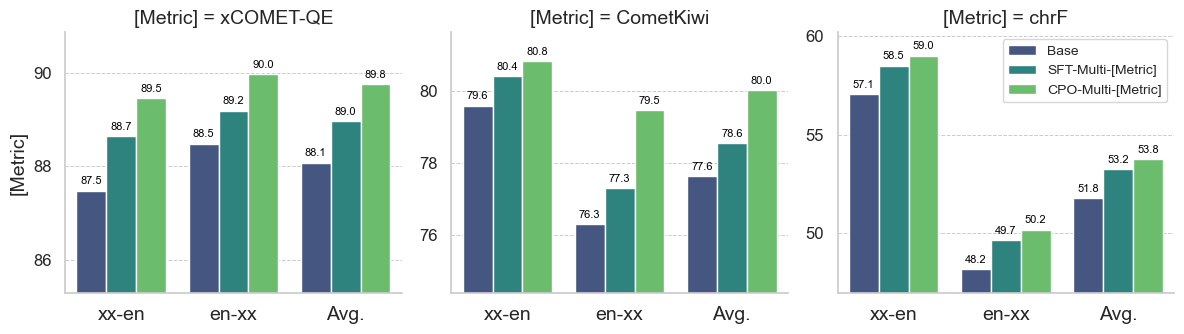

In [244]:
plt.figure(figsize=(4 * len(plot_info), 3.5))

for i, info in enumerate(plot_info):
    systems = info["systems"]
    metric = info["metric"]
    df = pd.DataFrame()
    df["lang_pair"] = ["xx-en"] * len(systems) + ["en-xx"] * len(systems) + ["Avg."] * len(systems)
    df["system"] = systems * 3
    df[metric] = None

    for sys in systems:
        df.loc[
            (df.lang_pair == "xx-en") & (df.system == sys), metric
        ] = eval_df.loc[eval_df.tgt_lang == "en", f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean()
        df.loc[
            (df.lang_pair == "en-xx") & (df.system == sys), metric
        ] = eval_df.loc[eval_df.src_lang == "en", f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean()
        df.loc[
            (df.lang_pair == "Avg.") & (df.system == sys), metric
        ] = eval_df[f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean()

    plt.subplot(1, len(plot_info), i+1)
    sns.set(style="whitegrid")
    palette = sns.color_palette("viridis", 3)
    barplot = sns.barplot(x='lang_pair', y=metric, hue='system', data=df, palette=palette)

    for p in barplot.patches:        
        height = p.get_height()
        if height > 0:
            barplot.annotate(format(height, '.1f'),
                            (p.get_x() + p.get_width() / 2., height),
                            ha='center', va='bottom',
                            xytext=(0, 3),
                            textcoords='offset points',
                            fontsize=8, color='black')

    barplot.set_xlabel('')
    barplot.set_ylabel(info["ylabel"], fontsize=14)
    barplot.set_yticks(info["yticks"])
    barplot.set_ylim(df[metric].min() * 0.975, df[metric].max() * info["ylim_sup"])
    barplot.tick_params(axis='x', labelsize=14)
    barplot.tick_params(axis='y', labelsize=12) 
    barplot.grid(True, which='major', axis='y', linestyle='--', linewidth=0.7)
    plt.title(f'[Metric] = {metric}', fontsize=14)
    plt.legend([],[], frameon=False)

handles, _ = barplot.get_legend_handles_labels()
labels = ['Base', 'SFT-Multi-[Metric]', 'CPO-Multi-[Metric]']
plt.legend(handles=handles, labels=labels, loc='upper right', fontsize=10)
plt.subplots_adjust(wspace=-1)
sns.despine()
plt.tight_layout()
# plt.savefig(f"/Users/hippolyte.gisserot-boukhlef/Desktop/Translation alignment/Figures/{file_name}.pdf")
plt.show()

## Figure 2

In [245]:
plot_info = [
    {
        "systems": ["Base", "CPO-Multi-xCOMET-QE-Choose-Base"], 
        "metric": "xCOMET-QE",
        "yticks": np.linspace(0, 100, 51),
        "ylim_sup": 1.015,
    },
]
file_name = "XXX"

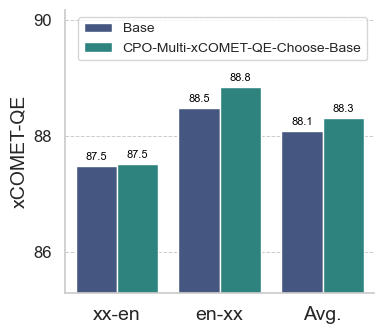

In [246]:
plt.figure(figsize=(4 * len(plot_info), 3.5))

for i, info in enumerate(plot_info):
    systems = info["systems"]
    metric = info["metric"]
    df = pd.DataFrame()
    df["lang_pair"] = ["xx-en"] * len(systems) + ["en-xx"] * len(systems) + ["Avg."] * len(systems)
    df["system"] = systems * 3
    df[metric] = None

    for sys in systems:
        df.loc[
            (df.lang_pair == "xx-en") & (df.system == sys), metric
        ] = eval_df.loc[eval_df.tgt_lang == "en", f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean()
        df.loc[
            (df.lang_pair == "en-xx") & (df.system == sys), metric
        ] = eval_df.loc[eval_df.src_lang == "en", f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean()
        df.loc[
            (df.lang_pair == "Avg.") & (df.system == sys), metric
        ] = eval_df[f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean()

    plt.subplot(1, len(plot_info), i+1)
    sns.set(style="whitegrid")
    palette = sns.color_palette("viridis", 3)
    barplot = sns.barplot(x='lang_pair', y=metric, hue='system', data=df, palette=palette)

    for p in barplot.patches:        
        height = p.get_height()
        if height > 0:
            barplot.annotate(format(height, '.1f'),
                            (p.get_x() + p.get_width() / 2., height),
                            ha='center', va='bottom',
                            xytext=(0, 3),
                            textcoords='offset points',
                            fontsize=8, color='black')

    barplot.set_xlabel('')
    barplot.set_ylabel(metric, fontsize=14)
    barplot.set_yticks(info["yticks"])
    barplot.set_ylim(df[metric].min() * 0.975, df[metric].max() * info["ylim_sup"])
    barplot.tick_params(axis='x', labelsize=14)
    barplot.tick_params(axis='y', labelsize=12) 
    barplot.grid(True, which='major', axis='y', linestyle='--', linewidth=0.7)

plt.legend(fontsize=10)
plt.subplots_adjust(wspace=-1)
sns.despine()
plt.tight_layout()
# plt.savefig(f"/Users/hippolyte.gisserot-boukhlef/Desktop/Translation alignment/Figures/{file_name}.pdf")
plt.show()

## Figure 3

In [255]:
plot_info = [
    {
        "systems": ["Base", "SFT-Multi-xCOMET-QE", "CPO-Multi-xCOMET-QE"],
        "metric": "chrF",
        "yticks": np.linspace(0, 100, 21),
        "ylim_sup": 1.02,
    },
]
file_name = "XXX"

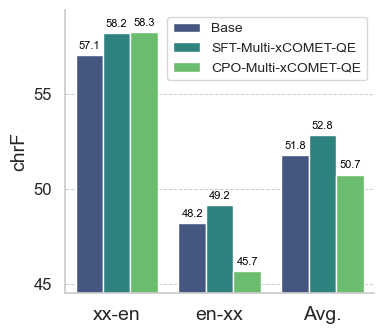

In [256]:
plt.figure(figsize=(4 * len(plot_info), 3.5))

for i, info in enumerate(plot_info):
    systems = info["systems"]
    metric = info["metric"]
    df = pd.DataFrame()
    df["lang_pair"] = ["xx-en"] * len(systems) + ["en-xx"] * len(systems) + ["Avg."] * len(systems)
    df["system"] = systems * 3
    df[metric] = None

    for sys in systems:
        df.loc[
            (df.lang_pair == "xx-en") & (df.system == sys), metric
        ] = eval_df.loc[eval_df.tgt_lang == "en", f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean()
        df.loc[
            (df.lang_pair == "en-xx") & (df.system == sys), metric
        ] = eval_df.loc[eval_df.src_lang == "en", f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean()
        df.loc[
            (df.lang_pair == "Avg.") & (df.system == sys), metric
        ] = eval_df[f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean()

    plt.subplot(1, len(plot_info), i+1)
    sns.set(style="whitegrid")
    palette = sns.color_palette("viridis", 3)
    barplot = sns.barplot(x='lang_pair', y=metric, hue='system', data=df, palette=palette)

    for p in barplot.patches:        
        height = p.get_height()
        if height > 0:
            barplot.annotate(format(height, '.1f'),
                            (p.get_x() + p.get_width() / 2., height),
                            ha='center', va='bottom',
                            xytext=(0, 3),
                            textcoords='offset points',
                            fontsize=8, color='black')

    barplot.set_xlabel('')
    barplot.set_ylabel(metric, fontsize=14)
    barplot.set_yticks(info["yticks"])
    barplot.set_ylim(df[metric].min() * 0.975, df[metric].max() * info["ylim_sup"])
    barplot.tick_params(axis='x', labelsize=14)
    barplot.tick_params(axis='y', labelsize=12) 
    barplot.grid(True, which='major', axis='y', linestyle='--', linewidth=0.7)

plt.legend(fontsize=10)
plt.subplots_adjust(wspace=-1)
sns.despine()
plt.tight_layout()
# plt.savefig(f"/Users/hippolyte.gisserot-boukhlef/Desktop/Translation alignment/Figures/{file_name}.pdf")
plt.show()

## Figure 4

In [277]:
plot_info = [
    {
        "systems": ["Base", "CPO-Multi-xCOMET-QE", "CPO-Mono-xCOMET-QE"],
        "metric": "xCOMET-QE",
        "yticks": np.linspace(0, 100, 51),
        "ylim_sup": 1.005,
    },
    {
        "systems": ["Base", "SFT-Multi-xCOMET-QE", "CPO-Multi-xCOMET-QE"],
        "metric": "chrF",
        "yticks": np.linspace(0, 100, 21),
        "ylim_sup": 1.02,
    },
]
file_name = "XXX"

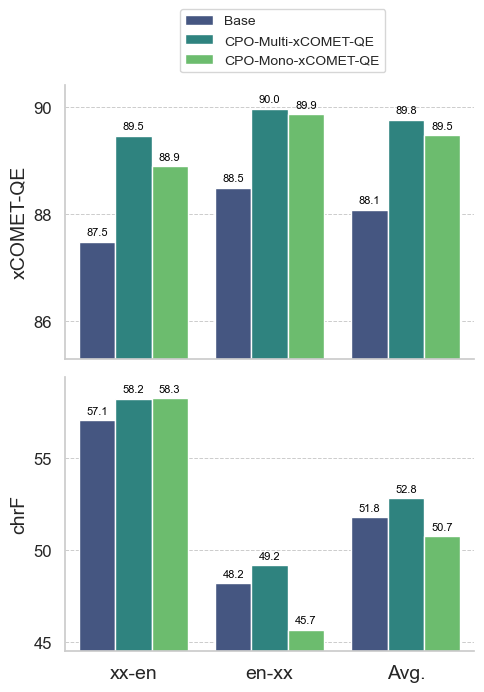

In [278]:
plt.figure(figsize=(5, 3.5 * len(plot_info)))

for i, info in enumerate(plot_info):
    systems = info["systems"]
    metric = info["metric"]
    df = pd.DataFrame()
    df["lang_pair"] = ["xx-en"] * len(systems) + ["en-xx"] * len(systems) + ["Avg."] * len(systems)
    df["system"] = systems * 3
    df[metric] = None

    for sys in systems:
        df.loc[
            (df.lang_pair == "xx-en") & (df.system == sys), metric
        ] = eval_df.loc[eval_df.tgt_lang == "en", f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean()
        df.loc[
            (df.lang_pair == "en-xx") & (df.system == sys), metric
        ] = eval_df.loc[eval_df.src_lang == "en", f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean()
        df.loc[
            (df.lang_pair == "Avg.") & (df.system == sys), metric
        ] = eval_df[f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean()

    plt.subplot(len(plot_info), 1, i+1)
    sns.set(style="whitegrid")
    palette = sns.color_palette("viridis", 3)
    barplot = sns.barplot(x='lang_pair', y=metric, hue='system', data=df, palette=palette)

    for p in barplot.patches:        
        height = p.get_height()
        if height > 0:
            barplot.annotate(format(height, '.1f'),
                            (p.get_x() + p.get_width() / 2., height),
                            ha='center', va='bottom',
                            xytext=(0, 3),
                            textcoords='offset points',
                            fontsize=8, color='black')
    
    barplot.set_xlabel('')
    
    if i == 0:
        barplot.set_xticks([])
        plt.legend(fontsize=10, bbox_to_anchor=(0.8,1.3))
    else:
        plt.legend([],[], frameon=False)
    barplot.set_ylabel(metric, fontsize=14)
    barplot.set_yticks(info["yticks"])
    barplot.set_ylim(df[metric].min() * 0.975, df[metric].max() * info["ylim_sup"])
    barplot.tick_params(axis='x', labelsize=14)
    barplot.tick_params(axis='y', labelsize=12) 
    barplot.grid(True, which='major', axis='y', linestyle='--', linewidth=0.7)

plt.subplots_adjust(wspace=-1)
sns.despine()
plt.tight_layout()
# plt.savefig(f"/Users/hippolyte.gisserot-boukhlef/Desktop/Translation alignment/Figures/{file_name}.pdf")
plt.show()

## Figure 5

In [347]:
plot_info = {
    "systems": [
        "CPO-Mono-xCOMET-QE-Choose-Low-Reject-Low",
        "CPO-Mono-xCOMET-QE-Choose-Low-Reject-Mid",
        "CPO-Mono-xCOMET-QE-Choose-Low-Reject-High",
        "CPO-Mono-xCOMET-QE-Choose-Mid-Reject-Low",
        "CPO-Mono-xCOMET-QE-Choose-Mid-Reject-Mid",
        "CPO-Mono-xCOMET-QE-Choose-Mid-Reject-High",
        "CPO-Mono-xCOMET-QE-Choose-High-Reject-Low",
        "CPO-Mono-xCOMET-QE-Choose-High-Reject-Mid",
        "CPO-Mono-xCOMET-QE-Choose-High-Reject-High",
    ],
    "metric": "xCOMET-QE",
}

In [ ]:
df = pd.DataFrame()
for sys in plot_info["systems"]:
    pref_data_name = f"ALMA-Preference-{sys[sys.find('-')+1:]}"
    pref_df = load_dataset(f"hgissbkh/{pref_data_name}")["train"].to_pandas()
    rej_metric = pref_df[f"rejected_{metrics_dict[plot_info['metric']]}"].mean()
    chos_metric = pref_df[f"chosen_{metrics_dict[plot_info['metric']]}"].mean()
    df.loc[chos_metric, rej_metric] = eval_df[f"{models_dict[sys]['short_name']}_{metrics_dict[plot_info['metric']]}"].mean()

100%|██████████| 9/9 [00:09<00:00,  1.04s/it]


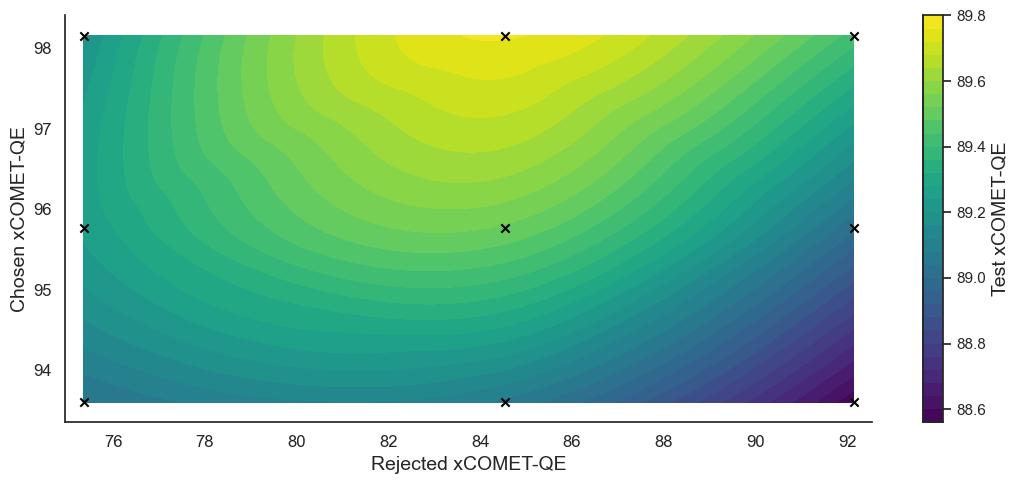

In [364]:
# Collect data
df = pd.DataFrame()
for sys in tqdm(plot_info["systems"]):
    pref_data_name = f"ALMA-Preference-{sys[sys.find('-')+1:]}"
    pref_df = load_dataset(f"hgissbkh/{pref_data_name}")["train"].to_pandas()
    rej_metric = pref_df[f"rejected_{metrics_dict[plot_info['metric']]}"].mean()
    chos_metric = pref_df[f"chosen_{metrics_dict[plot_info['metric']]}"].mean()
    df.loc[chos_metric, rej_metric] = eval_df[f"{models_dict[sys]['short_name']}_{metrics_dict[plot_info['metric']]}"].mean()

# Interpolate data
x1 = np.array(list(df.columns))
x2 = np.array(list(df.index))
f = df.values
x1_grid, x2_grid = np.meshgrid(x1, x2)
points = np.array([x1_grid.flatten(), x2_grid.flatten()]).T
values = f.flatten()
x1_new = np.linspace(x1.min(), x1.max(), 100)
x2_new = np.linspace(x2.min(), x2.max(), 100)
x1_new_grid, x2_new_grid = np.meshgrid(x1_new, x2_new)
f_new = griddata(points, values, (x1_new_grid, x2_new_grid), method='cubic')

# Make plot
plt.figure(figsize=(11, 5))
sns.set(style="white")
contour = plt.contourf(x1_new_grid, x2_new_grid, f_new, levels=30, cmap='viridis')
cbar = plt.colorbar(contour)
cbar.set_ticks([88.6, 88.8, 89, 89.2, 89.4, 89.6, 89.8])
cbar.set_label(f"Test {plot_info['metric']}", fontsize=14)
for chos in x2:
    for rej in x1:        
        plt.scatter(rej, chos, color="black", marker="x")
plt.xlabel(f"Rejected {plot_info['metric']}", fontsize=14)
plt.ylabel(f"Chosen {plot_info['metric']}", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(df.columns.min() - 0.4, df.columns.max() + 0.4)
plt.ylim(df.index.min() - 0.25, df.index.max() + 0.25)
sns.despine()
plt.tight_layout()
# plt.savefig(f"/Users/hippolyte.gisserot-boukhlef/Desktop/Translation alignment/Figures/qual_study.pdf", bbox_inches='tight')
plt.show()

## Figure 6

In [380]:
plot_info = [
    {
        "systems": ["Base", "CPO-Multi-xCOMET-QE", "CPO-Mono-xCOMET-QE-Optimized"],
        "metric": "xCOMET-QE",
        "yticks": np.linspace(0, 100, 51),
        "ylim_sup": 1.03,
    },
]
file_name = "XXX"

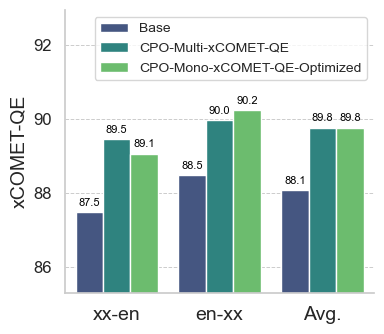

In [381]:
plt.figure(figsize=(4 * len(plot_info), 3.5))

for i, info in enumerate(plot_info):
    systems = info["systems"]
    metric = info["metric"]
    df = pd.DataFrame()
    df["lang_pair"] = ["xx-en"] * len(systems) + ["en-xx"] * len(systems) + ["Avg."] * len(systems)
    df["system"] = systems * 3
    df[metric] = None

    for sys in systems:
        df.loc[
            (df.lang_pair == "xx-en") & (df.system == sys), metric
        ] = eval_df.loc[eval_df.tgt_lang == "en", f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean()
        df.loc[
            (df.lang_pair == "en-xx") & (df.system == sys), metric
        ] = eval_df.loc[eval_df.src_lang == "en", f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean()
        df.loc[
            (df.lang_pair == "Avg.") & (df.system == sys), metric
        ] = eval_df[f"{models_dict[sys]['short_name']}_{metrics_dict[metric]}"].mean()

    plt.subplot(1, len(plot_info), i+1)
    sns.set(style="whitegrid")
    palette = sns.color_palette("viridis", 3)
    barplot = sns.barplot(x='lang_pair', y=metric, hue='system', data=df, palette=palette)

    for p in barplot.patches:        
        height = p.get_height()
        if height > 0:
            barplot.annotate(format(height, '.1f'),
                            (p.get_x() + p.get_width() / 2., height),
                            ha='center', va='bottom',
                            xytext=(0, 3),
                            textcoords='offset points',
                            fontsize=8, color='black')

    barplot.set_xlabel('')
    barplot.set_ylabel(metric, fontsize=14)
    barplot.set_yticks(info["yticks"])
    barplot.set_ylim(df[metric].min() * 0.975, df[metric].max() * info["ylim_sup"])
    barplot.tick_params(axis='x', labelsize=14)
    barplot.tick_params(axis='y', labelsize=12) 
    barplot.grid(True, which='major', axis='y', linestyle='--', linewidth=0.7)

plt.legend(fontsize=10)
plt.subplots_adjust(wspace=-1)
sns.despine()
plt.tight_layout()
# plt.savefig(f"/Users/hippolyte.gisserot-boukhlef/Desktop/Translation alignment/Figures/{file_name}.pdf")
plt.show()

## Table 1

In [33]:
systems = [ 
    "sft_xcomet_multi",
    "sft_kiwi_multi",
    "sft_chrf_multi_no_ref",
    "cpo_xcomet_multi",
    "cpo_xcomet_multi_cb",
    "cpo_kiwi_multi",
    "cpo_chrf_multi_no_ref",
    "cpo_xcomet_mono",
    "cpo_xcomet_mono_ch_rm",
]
metrics = ["xcomet", "kiwi", "chrf"]#, "bleu"]
#lps = ["en-cs", "en-de", "en-is", "en-ru", "en-zh", "en-xx", "xx-en", "Avg."]
lps = ["xx-en", "en-xx"]

In [34]:
recap_df = pd.DataFrame(
    index=["base"]
        + ["SFT-based methods"] + [sys for sys in systems if "sft" in sys] \
        + ["CPO-based methods", "Multi-system"] + [sys for sys in systems if "cpo" in sys and "multi" in sys] \
        + ["Mono-system"] + [sys for sys in systems if "cpo" in sys and "mono" in sys],
    columns=pd.MultiIndex.from_tuples(
        [(lp, cat, met) for lp in lps for cat in ["Neural", "Lexical"] for met in metrics + [""]
         if (met in ["chrf", "bleu"] and cat == "Lexical") or (met in ["xcomet", "kiwi"] and cat == "Neural") or met == ""][:-1]
    ),
    data=""
)
recap_df.index.name = "Model"

In [35]:
metrics = [("Neural", "xcomet"), ("Neural", "kiwi"), ("Lexical", "chrf")]#, ("Lexical", "bleu")]

In [36]:
for sys in ["base"] + systems:
    for lp in lps:
        for metric_type, metric in metrics:
            if lp not in ["xx-en", "en-xx", "Avg."]:
                recap_df.loc[sys, (lp, metric_type, metric)] = eval_df.loc[eval_df.lp == lp, f"{sys}_{metric}"].mean()
            elif lp == "xx-en":
                recap_df.loc[sys, (lp, metric_type, metric)] = eval_df.loc[eval_df.tgt_lang == "en", f"{sys}_{metric}"].mean()
            elif lp == "en-xx":
                recap_df.loc[sys, (lp, metric_type, metric)] = eval_df.loc[eval_df.src_lang == "en", f"{sys}_{metric}"].mean()
            elif lp == "Avg.":
                recap_df.loc[sys, (lp, metric_type, metric)] = eval_df[f"{sys}_{metric}"].mean()
recap_df.index = [metadata[idx]["clean_name"] if idx in metadata else idx for idx in recap_df.index]
recap_df.columns = pd.MultiIndex.from_tuples(
    [(lp, cat, metric_dict[met]) if met != "" else (lp, cat, met) for lp, cat, met in recap_df.columns]
)

In [37]:
recap_df

xx-en                                en-xx  \
                                 Neural                 Lexical       Neural   
                              xCOMET-QE  CometKiwi         chrF    xCOMET-QE   
Base                          87.479198  79.601284    57.067595    88.486331   
SFT-based methods                                                              
SFT-Multi-xCOMET-QE           88.652329  80.237267    58.222576    89.192741   
SFT-Multi-CometKiwi           88.751841  80.409709    58.417609    89.261332   
SFT-Multi-chrF                88.673908  80.236189    58.496088    88.814854   
CPO-based methods                                                              
Multi-system                                                                   
CPO-Multi-xCOMET-QE           89.462906  80.674853     58.25983    89.969298   
CPO-Multi-xCOMET-Choose-Base  87.508515  79.744063    57.107414    88.842469   
CPO-Multi-CometKiwi           89.283552  80.826009    58.657902    89.236149   
CPO-Multi-chrF                88.680809  80.336847    59.004607    87.579464   
Mono-system                                                                    
CPO-Mono-xCOMET-QE            88.892119   80.52016     57.99236    89.866701   
CPO-Mono-xCOMET-QE-Optimized  89.059853  80.709148    58.076395    90.241843   

                                                      
                                             Lexical  
                              CometKiwi         chrF  
Base                          76.316359     48.18455  
SFT-based methods                                     
SFT-Multi-xCOMET-QE           77.076256    49.160143  
SFT-Multi-CometKiwi           77.309698    49.255994  
SFT-Multi-chrF                76.239034    49.667643  
CPO-based methods                                     
Multi-system                                          
CPO-Multi-xCOMET-QE           79.497494    45.656784  
CPO-Multi-xCOMET-Choose-Base  76.704653    47.767266  
CPO-Multi-CometKiwi           79.486421    45.944748  
CPO-Multi-chrF                74.851743    50.188567  
Mono-system                                           
CPO-Mono-xCOMET-QE            78.792984    47.602912  
CPO-Mono-xCOMET-QE-Optimized  79.527413    47.547252

In [38]:
print(recap_df.to_latex(float_format="%.2f"))

\begin{tabular}{llllllllll}
\toprule
 & \multicolumn{5}{r}{xx-en} & \multicolumn{4}{r}{en-xx} \\
 & \multicolumn{3}{r}{Neural} & \multicolumn{2}{r}{Lexical} & \multicolumn{3}{r}{Neural} & Lexical \\
 & xCOMET-QE & CometKiwi &  & chrF &  & xCOMET-QE & CometKiwi &  & chrF \\
\midrule
Base & 87.48 & 79.60 &  & 57.07 &  & 88.49 & 76.32 &  & 48.18 \\
SFT-based methods &  &  &  &  &  &  &  &  &  \\
SFT-Multi-xCOMET-QE & 88.65 & 80.24 &  & 58.22 &  & 89.19 & 77.08 &  & 49.16 \\
SFT-Multi-CometKiwi & 88.75 & 80.41 &  & 58.42 &  & 89.26 & 77.31 &  & 49.26 \\
SFT-Multi-chrF & 88.67 & 80.24 &  & 58.50 &  & 88.81 & 76.24 &  & 49.67 \\
CPO-based methods &  &  &  &  &  &  &  &  &  \\
Multi-system &  &  &  &  &  &  &  &  &  \\
CPO-Multi-xCOMET-QE & 89.46 & 80.67 &  & 58.26 &  & 89.97 & 79.50 &  & 45.66 \\
CPO-Multi-xCOMET-Choose-Base & 87.51 & 79.74 &  & 57.11 &  & 88.84 & 76.70 &  & 47.77 \\
CPO-Multi-CometKiwi & 89.28 & 80.83 &  & 58.66 &  & 89.24 & 79.49 &  & 45.94 \\
CPO-Multi-chrF & 88.68 & 80.3

## Table 2

In [156]:
datasets = [
    "ALMA-Preference-Multi-System",
    "ALMA-Preference-Multi-System-XCOMET",
    "ALMA-Preference-Mono-System-XCOMET"]
metrics = ["xcomet", "chrf"]
file_name = "test"

In [162]:
recap_df = pd.DataFrame(
    index=pd.MultiIndex.from_tuples([(d, s) for d in datasets for s in ["Rejected", "Chosen"]]),
    columns=pd.MultiIndex.from_tuples([(l, m) for l in ["xx-en", "en-xx", "Avg."] for m in metrics + [""]])
)

In [163]:
for dat in datasets:
    pref_df = load_dataset(f"hgissbkh/{dat}")["train"].to_pandas()
    if dat == "ALMA-Preference-Multi-System":
        for metric in metrics:
            is_lexical = metric in ["chrf", "bleu"]
            for system in ["base", "gpt4", "ref"]:
                recap_df.loc[(dat, system), ("xx-en", metric)] = pref_df.loc[pref_df.tgt_lang == "en", f"{system}_{metric}"].mean() * (1 * is_lexical + 100 * (not is_lexical))
                recap_df.loc[(dat, system), ("en-xx", metric)] = pref_df.loc[pref_df.src_lang == "en", f"{system}_{metric}"].mean() * (1 * is_lexical + 100 * (not is_lexical))
                recap_df.loc[(dat, system), ("Avg.", metric)] = pref_df[f"{system}_{metric}"].mean() * (1 * is_lexical + 100 * (not is_lexical))    
    else:
        for metric in metrics:
            is_lexical = metric in ["chrf", "bleu"]
            recap_df.loc[(dat, "Rejected"), ("xx-en", metric)] = pref_df.loc[pref_df.tgt_lang == "en", f"rejected_{metric}"].mean() * (1 * is_lexical + 100 * (not is_lexical))
            recap_df.loc[(dat, "Chosen"), ("xx-en", metric)] = pref_df.loc[pref_df.tgt_lang == "en", f"chosen_{metric}"].mean() * (1 * is_lexical + 100 * (not is_lexical))
            recap_df.loc[(dat, "Rejected"), ("en-xx", metric)] = pref_df.loc[pref_df.src_lang == "en", f"rejected_{metric}"].mean() * (1 * is_lexical + 100 * (not is_lexical))
            recap_df.loc[(dat, "Chosen"), ("en-xx", metric)] = pref_df.loc[pref_df.src_lang == "en", f"chosen_{metric}"].mean() * (1 * is_lexical + 100 * (not is_lexical))
            recap_df.loc[(dat, "Rejected"), ("Avg.", metric)] = pref_df[f"rejected_{metric}"].mean() * (1 * is_lexical + 100 * (not is_lexical))
            recap_df.loc[(dat, "Chosen"), ("Avg.", metric)] = pref_df[f"chosen_{metric}"].mean() * (1 * is_lexical + 100 * (not is_lexical))
recap_df = recap_df.fillna("").iloc[:,:-1]

In [165]:
recap_df

xx-en               \
                                                 xcomet       chrf     
ALMA-Preference-Multi-System        Rejected                           
                                    Chosen                             
ALMA-Preference-Multi-System-XCOMET Rejected  85.962967  86.305511     
                                    Chosen    96.878686  73.620715     
ALMA-Preference-Mono-System-XCOMET  Rejected  88.344408  61.876993     
                                    Chosen    97.012426  63.337664     
ALMA-Preference-Multi-System        base      92.845293  64.044192     
                                    gpt4      94.832154   64.26949     
                                    ref       89.013022      100.0     

                                                  en-xx               \
                                                 xcomet       chrf     
ALMA-Preference-Multi-System        Rejected                           
                                    Chosen                             
ALMA-Preference-Multi-System-XCOMET Rejected  89.665384   71.02259     
                                    Chosen    97.588709  78.167907     
ALMA-Preference-Mono-System-XCOMET  Rejected  87.285764  49.795963     
                                    Chosen    97.558384  51.297781     
ALMA-Preference-Multi-System        base      93.316279  52.870784     
                                    gpt4      94.341582  57.734561     
                                    ref       94.533511      100.0     

                                                   Avg.             
                                                 xcomet       chrf  
ALMA-Preference-Multi-System        Rejected                        
                                    Chosen                          
ALMA-Preference-Multi-System-XCOMET Rejected  87.857813  78.483924  
                                    Chosen    97.242066  75.947905  
ALMA-Preference-Mono-System-XCOMET  Rejected  87.802609  55.694089  
                                    Chosen     97.29184  57.175819  
ALMA-Preference-Multi-System        base      93.086337  58.325796  
                                    gpt4      94.581086  60.925004  
                                    ref       91.838332      100.0

In [166]:
print(recap_df.to_latex(float_format="%.2f"))

\begin{tabular}{llllllllll}
\toprule
 &  & \multicolumn{3}{r}{xx-en} & \multicolumn{3}{r}{en-xx} & \multicolumn{2}{r}{Avg.} \\
 &  & xcomet & chrf &  & xcomet & chrf &  & xcomet & chrf \\
\midrule
\multirow[t]{2}{*}{ALMA-Preference-Multi-System} & Rejected &  &  &  &  &  &  &  &  \\
 & Chosen &  &  &  &  &  &  &  &  \\
\cline{1-10}
\multirow[t]{2}{*}{ALMA-Preference-Multi-System-XCOMET} & Rejected & 85.96 & 86.31 &  & 89.67 & 71.02 &  & 87.86 & 78.48 \\
 & Chosen & 96.88 & 73.62 &  & 97.59 & 78.17 &  & 97.24 & 75.95 \\
\cline{1-10}
\multirow[t]{2}{*}{ALMA-Preference-Mono-System-XCOMET} & Rejected & 88.34 & 61.88 &  & 87.29 & 49.80 &  & 87.80 & 55.69 \\
 & Chosen & 97.01 & 63.34 &  & 97.56 & 51.30 &  & 97.29 & 57.18 \\
\cline{1-10}
\multirow[t]{3}{*}{ALMA-Preference-Multi-System} & base & 92.85 & 64.04 &  & 93.32 & 52.87 &  & 93.09 & 58.33 \\
 & gpt4 & 94.83 & 64.27 &  & 94.34 & 57.73 &  & 94.58 & 60.93 \\
 & ref & 89.01 & 100.00 &  & 94.53 & 100.00 &  & 91.84 & 100.00 \\
\cline{1-10}
\

# Appendix

In [307]:
metrics = ["xcomet", "kiwi", "chrf", "bleu"]
systems = [
    "base", 
    # "sft_xcomet_multi",
    "cpo_xcomet_multi",
    # "cpo_xcomet_multi_cb",
    # "cpo_xcomet_mono",
    # "sft_kiwi_multi",
    # "cpo_kiwi_multi",
    # "sft_chrf_multi_no_ref",
    # "cpo_chrf_multi_no_ref",
    "cpo_xcomet_mono_cl_rl",
    "cpo_xcomet_mono_cl_rm",
    "cpo_xcomet_mono_cl_rh",
    "cpo_xcomet_mono_cm_rl",
    "cpo_xcomet_mono_cm_rm",
    "cpo_xcomet_mono_cm_rh",
    "cpo_xcomet_mono_ch_rl",
    "cpo_xcomet_mono_ch_rm",
    "cpo_xcomet_mono_ch_rh",
]
lps = [
    # "cs-en", 
    # "en-cs", 
    # "en-de", 
    # "de-en", 
    # "is-en", 
    # "en-is", 
    # "ru-en", 
    # "en-ru", 
    "zh-en", 
    "en-zh",
    "xx-en",
    "en-xx",
]

In [308]:
recap_df = pd.DataFrame(
    index=systems,
    columns=pd.MultiIndex.from_tuples([(l,m) for l in lps for m in metrics + [""]])
)

for sys in systems:
    for metric in metrics:        
        for lp in lps:
            if lp == "xx-en":
                recap_df.loc[sys, (lp, metric)] = eval_df.loc[eval_df.tgt_lang == "en", f"{sys}_{metric}"].mean()
            elif lp == "en-xx":
                recap_df.loc[sys, (lp, metric)] = eval_df.loc[eval_df.src_lang == "en", f"{sys}_{metric}"].mean()
            else:
                recap_df.loc[sys, (lp, metric)] = eval_df.loc[eval_df.lp == lp, f"{sys}_{metric}"].mean()

recap_df.index = [metadata[s]["clean_name"] for s in recap_df.index]
recap_df.index.name = "Systems"
recap_df.columns = pd.MultiIndex.from_tuples([(l, metric_dict[m]) if m != "" else (l, "") for l, m in recap_df.columns])
recap_df = recap_df.fillna("")
recap_df = recap_df.iloc[:,:-1]

In [309]:
recap_df

zh-en                        \
                                            XCOMET       KIWI       chrF   
Systems                                                                    
Base                                     89.984432  75.212949  48.272530   
CPO-Multi-XCOMET                         91.496393  76.955927  49.100938   
CPO-Mono-XCOMET-Choose-Low-Reject-Low    90.821805  76.755422  49.217560   
CPO-Mono-XCOMET-Choose-Low-Reject-Mid    90.664901  76.298865  49.018953   
CPO-Mono-XCOMET-Choose-Low-Reject-High   90.140723  75.758877  48.702321   
CPO-Mono-XCOMET-Choose-Mid-Reject-Low    90.896741  76.815053  49.067381   
CPO-Mono-XCOMET-Choose-Mid-Reject-Mid    91.143577  76.801759  49.162389   
CPO-Mono-XCOMET-Choose-Mid-Reject-High   90.706752  76.289235  49.009946   
CPO-Mono-XCOMET-Choose-High-Reject-Low   90.730501  76.543966  48.852326   
CPO-Mono-XCOMET-Choose-High-Reject-Mid   91.434061  76.945492  49.173659   
CPO-Mono-XCOMET-Choose-High-Reject-High  91.100898  76.540780  49.083629   

                                                          en-zh             \
                                              BLEU       XCOMET       KIWI   
Systems                                                                      
Base                                     20.198397    85.598122  73.995345   
CPO-Multi-XCOMET                         20.355595    87.463444  77.109652   
CPO-Mono-XCOMET-Choose-Low-Reject-Low    20.556286    86.783880  76.195385   
CPO-Mono-XCOMET-Choose-Low-Reject-Mid    20.511071    86.653119  75.927987   
CPO-Mono-XCOMET-Choose-Low-Reject-High   20.402222    85.977459  74.645876   
CPO-Mono-XCOMET-Choose-Mid-Reject-Low    20.211383    87.412332  77.084361   
CPO-Mono-XCOMET-Choose-Mid-Reject-Mid    20.424640    87.383447  77.027863   
CPO-Mono-XCOMET-Choose-Mid-Reject-High   20.506032    86.513610  75.788521   
CPO-Mono-XCOMET-Choose-High-Reject-Low   19.870858    87.740745  77.588708   
CPO-Mono-XCOMET-Choose-High-Reject-Mid   20.317367    87.932713  77.873000   
CPO-Mono-XCOMET-Choose-High-Reject-High  20.490634    87.269842  76.881260   

                                                                     xx-en  \
                                              chrF       BLEU       XCOMET   
Systems                                                                      
Base                                     34.907315  35.438921    87.479198   
CPO-Multi-XCOMET                         31.200202  29.727137    89.462906   
CPO-Mono-XCOMET-Choose-Low-Reject-Low    34.736514  35.099590    88.594739   
CPO-Mono-XCOMET-Choose-Low-Reject-Mid    34.650787  34.961830    88.545366   
CPO-Mono-XCOMET-Choose-Low-Reject-High   35.131059  35.636394    88.052293   
CPO-Mono-XCOMET-Choose-Mid-Reject-Low    34.392185  34.431394    88.662736   
CPO-Mono-XCOMET-Choose-Mid-Reject-Mid    34.353957  34.456151    88.865494   
CPO-Mono-XCOMET-Choose-Mid-Reject-High   34.722872  35.042023    88.478101   
CPO-Mono-XCOMET-Choose-High-Reject-Low   33.612824  33.387803    88.485632   
CPO-Mono-XCOMET-Choose-High-Reject-Mid   33.510616  33.194181    89.059853   
CPO-Mono-XCOMET-Choose-High-Reject-High  34.175499  34.293668    88.781397   

                                                                            \
                                              KIWI       chrF       BLEU     
Systems                                                                      
Base                                     79.601284  57.067595  30.174614     
CPO-Multi-XCOMET                         80.674853  58.259830  30.942868     
CPO-Mono-XCOMET-Choose-Low-Reject-Low    80.416864  58.007152  30.789254     
CPO-Mono-XCOMET-Choose-Low-Reject-Mid    80.323444  57.982579  30.822937     
CPO-Mono-XCOMET-Choose-Low-Reject-High   80.020358  57.760013  30.767841     
CPO-Mono-XCOMET-Choose-Mid-Reject-Low    80.457884  57.906736  30.521714     
CPO-Mono-XCOMET-Choose-Mid-Reject-Mid    80.532453  58.028370  30.711980     
CPO-Mono-XCOME

In [310]:
print(recap_df.to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrlrrrrlrrrrlrrrr}
\toprule
 & \multicolumn{5}{r}{zh-en} & \multicolumn{5}{r}{en-zh} & \multicolumn{5}{r}{xx-en} & \multicolumn{4}{r}{en-xx} \\
 & XCOMET & KIWI & chrF & BLEU &  & XCOMET & KIWI & chrF & BLEU &  & XCOMET & KIWI & chrF & BLEU &  & XCOMET & KIWI & chrF & BLEU \\
Systems &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
Base & 89.98 & 75.21 & 48.27 & 20.20 &  & 85.60 & 74.00 & 34.91 & 35.44 &  & 87.48 & 79.60 & 57.07 & 30.17 &  & 88.49 & 76.32 & 48.18 & 28.96 \\
CPO-Multi-XCOMET & 91.50 & 76.96 & 49.10 & 20.36 &  & 87.46 & 77.11 & 31.20 & 29.73 &  & 89.46 & 80.67 & 58.26 & 30.94 &  & 89.97 & 79.50 & 45.66 & 25.35 \\
CPO-Mono-XCOMET-Choose-Low-Reject-Low & 90.82 & 76.76 & 49.22 & 20.56 &  & 86.78 & 76.20 & 34.74 & 35.10 &  & 88.59 & 80.42 & 58.01 & 30.79 &  & 89.33 & 78.23 & 48.40 & 28.85 \\
CPO-Mono-XCOMET-Choose-Low-Reject-Mid & 90.66 & 76.30 & 49.02 & 20.51 &  & 86.65 & 75.93 & 34.65 & 34.96 &  & 88.55 & 80.32 & 57.98 & 30.82 &  & 89

In [381]:
metrics = ["xcomet", "kiwi", "chrf", "bleu"]
datasets = [
    # "ALMA-Preference-Multi-System",
    # "ALMA-Preference-Multi-System-XCOMET",
    # "ALMA-Preference-Multi-System-XCOMET-Choose-Base",
    # "ALMA-Preference-Mono-System-XCOMET",
    # "ALMA-Preference-Multi-System-KIWI",
    # "ALMA-Preference-Multi-System-chrF",
    # "ALMA-Preference-Multi-System-No-Reference-chrF",
    "ALMA-Preference-Mono-System-XCOMET-Choose-Low-Reject-Low",
    "ALMA-Preference-Mono-System-XCOMET-Choose-Low-Reject-Mid",
    "ALMA-Preference-Mono-System-XCOMET-Choose-Low-Reject-High",
    "ALMA-Preference-Mono-System-XCOMET-Choose-Mid-Reject-Low",
    "ALMA-Preference-Mono-System-XCOMET-Choose-Mid-Reject-Mid",
    "ALMA-Preference-Mono-System-XCOMET-Choose-Mid-Reject-High",
    "ALMA-Preference-Mono-System-XCOMET-Choose-High-Reject-Low",
    "ALMA-Preference-Mono-System-XCOMET-Choose-High-Reject-Mid",
    "ALMA-Preference-Mono-System-XCOMET-Choose-High-Reject-High",
]
lps = [
    "cs-en", 
    "en-cs", 
    "en-de", 
    "de-en", 
    "is-en", 
    "en-is", 
    "ru-en", 
    "en-ru", 
    "zh-en", 
    "en-zh",
    "xx-en",
    "en-xx",
]

In [382]:
recap_df = pd.DataFrame(
    index=pd.MultiIndex.from_tuples(
        # [("ALMA-Preference-Multi-System", "Base"), ("ALMA-Preference-Multi-System", "GPT4"), ("ALMA-Preference-Multi-System", "Reference")]
        []
        + [(d, s) for d in datasets for s in ["Rejected", "Chosen"]]
    ),
    columns=pd.MultiIndex.from_tuples([(l, m) for l in lps for m in metrics + [""]])
)
for dat in tqdm(datasets):
    pref_df = load_dataset(f"hgissbkh/{dat}")["train"].to_pandas()
    for metric in metrics:
        is_lexical = metric in ["chrf", "bleu"]
        for lp in lps:
            if dat == "ALMA-Preference-Multi-System":
                if lp == "xx-en":
                    recap_df.loc[(dat, "Base"), (lp, metric)] = pref_df.loc[pref_df.tgt_lang == "en", f"base_{metric}"].mean() * (1 * is_lexical + 100 * (not is_lexical))
                    recap_df.loc[(dat, "GPT4"), (lp, metric)] = pref_df.loc[pref_df.tgt_lang == "en", f"gpt4_{metric}"].mean() * (1 * is_lexical + 100 * (not is_lexical))
                    recap_df.loc[(dat, "Reference"), (lp, metric)] = pref_df.loc[pref_df.tgt_lang == "en", f"ref_{metric}"].mean() * (1 * is_lexical + 100 * (not is_lexical))
                elif lp == "en-xx":
                    recap_df.loc[(dat, "Base"), (lp, metric)] = pref_df.loc[pref_df.src_lang == "en", f"base_{metric}"].mean() * (1 * is_lexical + 100 * (not is_lexical))
                    recap_df.loc[(dat, "GPT4"), (lp, metric)] = pref_df.loc[pref_df.src_lang == "en", f"gpt4_{metric}"].mean() * (1 * is_lexical + 100 * (not is_lexical))
                    recap_df.loc[(dat, "Reference"), (lp, metric)] = pref_df.loc[pref_df.src_lang == "en", f"ref_{metric}"].mean() * (1 * is_lexical + 100 * (not is_lexical))
                else:
                    recap_df.loc[(dat, "Base"), (lp, metric)] = pref_df.loc[pref_df.lp == lp, f"base_{metric}"].mean() * (1 * is_lexical + 100 * (not is_lexical))
                    recap_df.loc[(dat, "GPT4"), (lp, metric)] = pref_df.loc[pref_df.lp == lp, f"gpt4_{metric}"].mean() * (1 * is_lexical + 100 * (not is_lexical))
                    recap_df.loc[(dat, "Reference"), (lp, metric)] = pref_df.loc[pref_df.lp == lp, f"ref_{metric}"].mean() * (1 * is_lexical + 100 * (not is_lexical))             
            else:
                if lp == "xx-en":
                    recap_df.loc[(dat, "Rejected"), (lp, metric)] = pref_df.loc[pref_df.tgt_lang == "en", f"rejected_{metric}"].mean() * (1 * is_lexical + 100 * (not is_lexical))
                    recap_df.loc[(dat, "Chosen"), (lp, metric)] = pref_df.loc[pref_df.tgt_lang == "en", f"chosen_{metric}"].mean() * (1 * is_lexical + 100 * (not is_lexical))
                elif lp == "en-xx":
                    recap_df.loc[(dat, "Rejected"), (lp, metric)] = pref_df.loc[pref_df.src_lang == "en", f"rejected_{metric}"].mean() * (1 * is_lexical + 100 * (not is_lexical))
                    recap_df.loc[(dat, "Chosen"), (lp, metric)] = pref_df.loc[pref_df.src_lang == "en", f"chosen_{metric}"].mean() * (1 * is_lexical + 100 * (not is_lexical))
                else:
                    recap_df.loc[(dat, "Rejected"), (lp, metric)] = pref_df.loc[pref_df.lp == lp, f"rejected_{metric}"].mean() * (1 * is_lexical + 100 * (not is_lexical))
                    recap_df.loc[(dat, "Chosen"), (lp, metric)] = pref_df.loc[pref_df.lp == lp, f"chosen_{metric}"].mean() * (1 * is_lexical + 100 * (not is_lexical))
recap_df.index = pd.MultiIndex.from_tuples([(d[d.find("-M")+1:], s) for d, s in recap_df.index])
recap_df.columns = pd.MultiIndex.from_tuples([(l, metric_dict[m]) if m != "" else (l, "") for l, m in recap_df.columns])
recap_df = recap_df.fillna("")
recap_df = recap_df.iloc[:,:-1]

100%|██████████| 9/9 [00:11<00:00,  1.26s/it]


In [383]:
recap_df

zh-en             \
                                                        XCOMET       KIWI   
Mono-System-XCOMET-Choose-Low-Reject-Low   Rejected  84.119849  78.540373   
                                           Chosen    96.005120  85.638941   
Mono-System-XCOMET-Choose-Low-Reject-Mid   Rejected  90.700264  82.421583   
                                           Chosen    96.005120  85.638941   
Mono-System-XCOMET-Choose-Low-Reject-High  Rejected  94.902023  84.295524   
                                           Chosen    96.005120  85.638941   
Mono-System-XCOMET-Choose-Mid-Reject-Low   Rejected  84.119849  78.540373   
                                           Chosen    97.345115  86.314028   
Mono-System-XCOMET-Choose-Mid-Reject-Mid   Rejected  90.700264  82.421583   
                                           Chosen    97.345115  86.314028   
Mono-System-XCOMET-Choose-Mid-Reject-High  Rejected  94.902023  84.295524   
                                           Chosen    97.345115  86.314028   
Mono-System-XCOMET-Choose-High-Reject-Low  Rejected  84.119849  78.540373   
                                           Chosen    98.936307  87.100723   
Mono-System-XCOMET-Choose-High-Reject-Mid  Rejected  90.700264  82.421583   
                                           Chosen    98.936307  87.100723   
Mono-System-XCOMET-Choose-High-Reject-High Rejected  94.902023  84.295524   
                                           Chosen    98.936307  87.100723   

                                                                             \
                                                          chrF       BLEU     
Mono-System-XCOMET-Choose-Low-Reject-Low   Rejected  53.315957  23.547678     
                                           Chosen    57.109069  27.071997     
Mono-System-XCOMET-Choose-Low-Reject-Mid   Rejected  55.139710  25.245123     
                                           Chosen    57.109069  27.071997     
Mono-System-XCOMET-Choose-Low-Reject-High  Rejected  55.873105  25.712876     
                                           Chosen    57.109069  27.071997     
Mono-System-XCOMET-Choose-Mid-Reject-Low   Rejected  53.315957  23.547678     
                                           Chosen    57.499870  27.433332     
Mono-System-XCOMET-Choose-Mid-Reject-Mid   Rejected  55.139710  25.245123     
                                           Chosen    57.499870  27.433332     
Mono-System-XCOMET-Choose-Mid-Reject-High  Rejected  55.873105  25.712876     
                                           Chosen    57.499870  27.433332     
Mono-System-XCOMET-Choose-High-Reject-Low  Rejected  53.315957  23.547678     
                                           Chosen    57.622424  27.506386     
Mono-System-XCOMET-Choose-High-Reject-Mid  Rejected  55.139710  25.245123     
                                           Chosen    57.622424  27.506386     
Mono-System-XCOMET-Choose-High-Reject-High Rejected  55.873105  25.712876     
                                           Chosen    57.622424  27.506386     

                                                         en-zh             \
                                                        XCOMET       KIWI   
Mono-System-XCOMET-Choose-Low-Reject-Low   Rejected  61.377256  66.087171   
                                           Chosen    88.836266  83.010123   
Mono-System-XCOMET-Choose-Low-Reject-Mid   Rejected  74.865667  74.196261   
                                           Chosen    88.836266  83.010123   
Mono-System-XCOMET-Choose-Low-Reject-High  Rejected  87.345266  81.503316   
                                           Chosen    88.836266  83.010123   
Mono-System-XCOMET-Choose-Mid-Reject-Low   Rejected  61.377256  66.087171   
                                           Chosen    92.427731  85.235677   
Mono-System-XCOMET-Choose-Mid-Reject-Mid   Rejected  74.865667  74.196261   
                                           Chosen    92.427731  85.235677   
Mono-System

In [384]:
print(recap_df.to_latex(float_format="%.2f"))

\begin{tabular}{llrrrrlrrrrlrrrrlrrrr}
\toprule
 &  & \multicolumn{5}{r}{zh-en} & \multicolumn{5}{r}{en-zh} & \multicolumn{5}{r}{xx-en} & \multicolumn{4}{r}{en-xx} \\
 &  & XCOMET & KIWI & chrF & BLEU &  & XCOMET & KIWI & chrF & BLEU &  & XCOMET & KIWI & chrF & BLEU &  & XCOMET & KIWI & chrF & BLEU \\
\midrule
\multirow[t]{2}{*}{Mono-System-XCOMET-Choose-Low-Reject-Low} & Rejected & 84.12 & 78.54 & 53.32 & 23.55 &  & 61.38 & 66.09 & 28.23 & 29.08 &  & 78.28 & 83.39 & 59.54 & 31.91 &  & 72.57 & 67.90 & 46.68 & 24.36 \\
 & Chosen & 96.01 & 85.64 & 57.11 & 27.07 &  & 88.84 & 83.01 & 33.71 & 35.64 &  & 93.40 & 88.51 & 63.24 & 35.62 &  & 93.79 & 85.64 & 51.32 & 28.98 \\
\cline{1-21}
\multirow[t]{2}{*}{Mono-System-XCOMET-Choose-Low-Reject-Mid} & Rejected & 90.70 & 82.42 & 55.14 & 25.25 &  & 74.87 & 74.20 & 30.47 & 31.96 &  & 85.51 & 85.98 & 61.18 & 33.41 &  & 83.61 & 76.28 & 48.96 & 26.53 \\
 & Chosen & 96.01 & 85.64 & 57.11 & 27.07 &  & 88.84 & 83.01 & 33.71 & 35.64 &  & 93.40 & 88.51 & 63.

In [5]:
num_samples = {}
lps = ["cs-en", "de-en", "is-en", "ru-en", "zh-en"]
for lp in lps:
    ds = load_dataset("haoranxu/ALMA-R-Preference", lp)["train"]
    num_samples[lp] = len(ds)

In [6]:
num_samples

{'cs-en': 2009, 'de-en': 3065, 'is-en': 2009, 'ru-en': 2009, 'zh-en': 3065}

In [9]:
total_sum_samples = sum(list(num_samples.values()))

In [12]:
{k: v / total_sum_samples for k, v in num_samples.items()}

{'cs-en': 0.1652545858353212,
 'de-en': 0.25211812124701816,
 'is-en': 0.1652545858353212,
 'ru-en': 0.1652545858353212,
 'zh-en': 0.25211812124701816}

In [15]:
ds = load_dataset("hgissbkh/ALMA-Preference-Multi-System")["train"].to_pandas()

In [22]:
lps = [
    "cs-en", 
    "en-cs", 
    "en-de", 
    "de-en", 
    "is-en", 
    "en-is", 
    "ru-en", 
    "en-ru", 
    "zh-en", 
    "en-zh",
]

In [27]:
for lp in lps:
    print(lp, ":", len(ds[ds.lp == lp]) / len(ds))

cs-en : 0.09764277035236937
en-cs : 0.09764277035236937
en-de : 0.10750911300121507
de-en : 0.09764277035236937
is-en : 0.09764277035236937
en-is : 0.09764277035236937
ru-en : 0.09764277035236937
en-ru : 0.09764277035236937
zh-en : 0.09764277035236937
en-zh : 0.1113487241798299


In [20]:
len(ds)

20575